<a href="https://www.kaggle.com/code/iqmansingh/smoker-status-stratifiedkfold-catboost-lgbm?scriptVersionId=148138653" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="display:fill;
           background-color:#DDDDDD;
           letter-spacing:0.5px;border-bottom: 2px solid black;">
<img src="https://raw.githubusercontent.com/IqmanS/Machine-Learning-Notebooks/main/smoker_status_prediction/smoking-banner.jpg">
    
<H1 style="padding: 20px; color:black; font-weight:600;font-family: 'Garamond', 'Lucida Sans', sans-serif; text-align: center; font-size: 36px;">PREDICTION OF SMOKER STATUS</H1>
</div>


In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark") # Theme for plots as Dark
sns.set_palette("viridis")
# sns.color_palette("flare")
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import optuna
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from catboost import Pool, CatBoostClassifier, cv

<div style="background-color: #DDDDDD; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Table of Contents
    </h1>
</div>

<a href="#1" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 22px;"> 1. Dataset Overview </a><br>
<a href="#2" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 22px;"> 2. Basic Feature Engineering </a> <br>
<a href="#3" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 22px;"> 3. Exploratory Data Analysis & Visualization </a> <br>
<a href="#4" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 22px;"> 4. Training Models </a><br>
<a href="#4.1" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 16px;padding-left: 25px;"> 4.1 Baseline LGBM Model </a><br>
<a href="#4.2" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 16px;padding-left: 25px;"> 4.2 Optuna Tuning LGBM Model </a><br>
<a href="#4.3" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 16px;padding-left: 25px;"> 4.3 StratifiedKFold LGBM Preds </a><br>
<a href="#4.4" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 16px;padding-left: 25px;"> 4.4 StratifiedKFold CatBoost Preds </a><br>
<a href="#6" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 22px;"> 5. Plotting Feature Importance </a><br>
<a href="#7" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 22px;"> 6. Creating 'submission.csv' </a><br>
<a href="#8" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #323232;font-size: 22px;"> 7. Conclusion </a>

<div id="1" style="background-color: #DDDDDD; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #000000; font-weight: bold; font-size: 42px;">
    Dataset Overview
    </h1>
</div>

In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s3e24/train.csv",index_col="id")
orig_data = pd.read_csv("/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s3e24/test.csv",index_col="id")
train_data = pd.concat([train_data,orig_data])

In [3]:
train_data.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1


In [4]:
test_data.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
id,,,,,,,,,,,,,,,,,,,,,
159256,40,165,70,84.0,1.2,1.2,1,1,130,89,...,186,49,115,14.2,1,0.9,19,25,32,0
159257,80,160,60,93.0,1.0,1.0,2,2,144,72,...,158,35,104,13.0,1,1.1,20,12,24,0
159258,60,170,70,86.5,0.6,0.7,1,1,117,75,...,173,39,88,15.4,1,1.4,38,60,36,0
159259,40,160,50,67.0,0.3,0.4,1,1,116,62,...,47,75,128,14.5,1,0.6,25,18,10,1
159260,40,170,75,89.4,1.0,0.9,1,1,132,94,...,100,39,123,16.5,1,1.0,30,39,27,1


<div id="2" style="background-color: #DDDDDD; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #000000; font-weight: bold; font-size: 42px;">
    Basic Feature Engineering
    </h1>
</div>

In [5]:
train_data["BMI"] = train_data["weight(kg)"] / (train_data["height(cm)"]/100)**2
train_data["HDL-LDL Ratio"] = train_data["HDL"] / train_data["LDL"]
train_data["HDL-triglyceride Ratio"] = train_data["HDL"] / train_data["triglyceride"]
train_data["LDL-triglyceride Ratio"] = train_data["LDL"] / train_data["triglyceride"]
# train_data["HDL-Cholesterol Ratio"] = train_data["HDL"] / train_data["Cholesterol"]
# train_data["LDL-Cholesterol Ratio"] = train_data["LDL"] / train_data["Cholesterol"]
train_data["Liver Enzyme Ratio"] = train_data["AST"] / train_data["ALT"]

In [6]:
test_data["BMI"] = test_data["weight(kg)"] / (test_data["height(cm)"]/100)**2
test_data["HDL-LDL Ratio"] = test_data["HDL"] / test_data["LDL"]
test_data["HDL-triglyceride Ratio"] = test_data["HDL"] / test_data["triglyceride"]
test_data["LDL-triglyceride Ratio"] = test_data["LDL"] / test_data["triglyceride"]
# test_data["HDL-Cholesterol Ratio"] = test_data["HDL"] / test_data["Cholesterol"]
# test_data["LDL-Cholesterol Ratio"] = test_data["LDL"] / test_data["Cholesterol"]
test_data["Liver Enzyme Ratio"] = test_data["AST"] / test_data["ALT"]

In [7]:
train_data.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,AST,ALT,Gtp,dental caries,smoking,BMI,HDL-LDL Ratio,HDL-triglyceride Ratio,LDL-triglyceride Ratio,Liver Enzyme Ratio
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,22,25,27,0,1,22.038567,0.533333,0.133333,0.250000,0.880000
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,27,23,37,1,0,23.875115,0.452381,1.036364,2.290909,1.173913
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,27,31,53,0,1,25.951557,0.483871,0.228426,0.472081,0.870968
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,20,27,30,1,0,29.320988,0.372549,0.187192,0.502463,0.740741
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,19,13,17,0,1,22.038567,0.473118,0.505747,1.068966,1.461538


<div id="3" style="background-color: #DDDDDD; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #000000; font-weight: bold; font-size: 42px;">
    Exploratory Data Analysis & Visualization
    </h1>
</div>

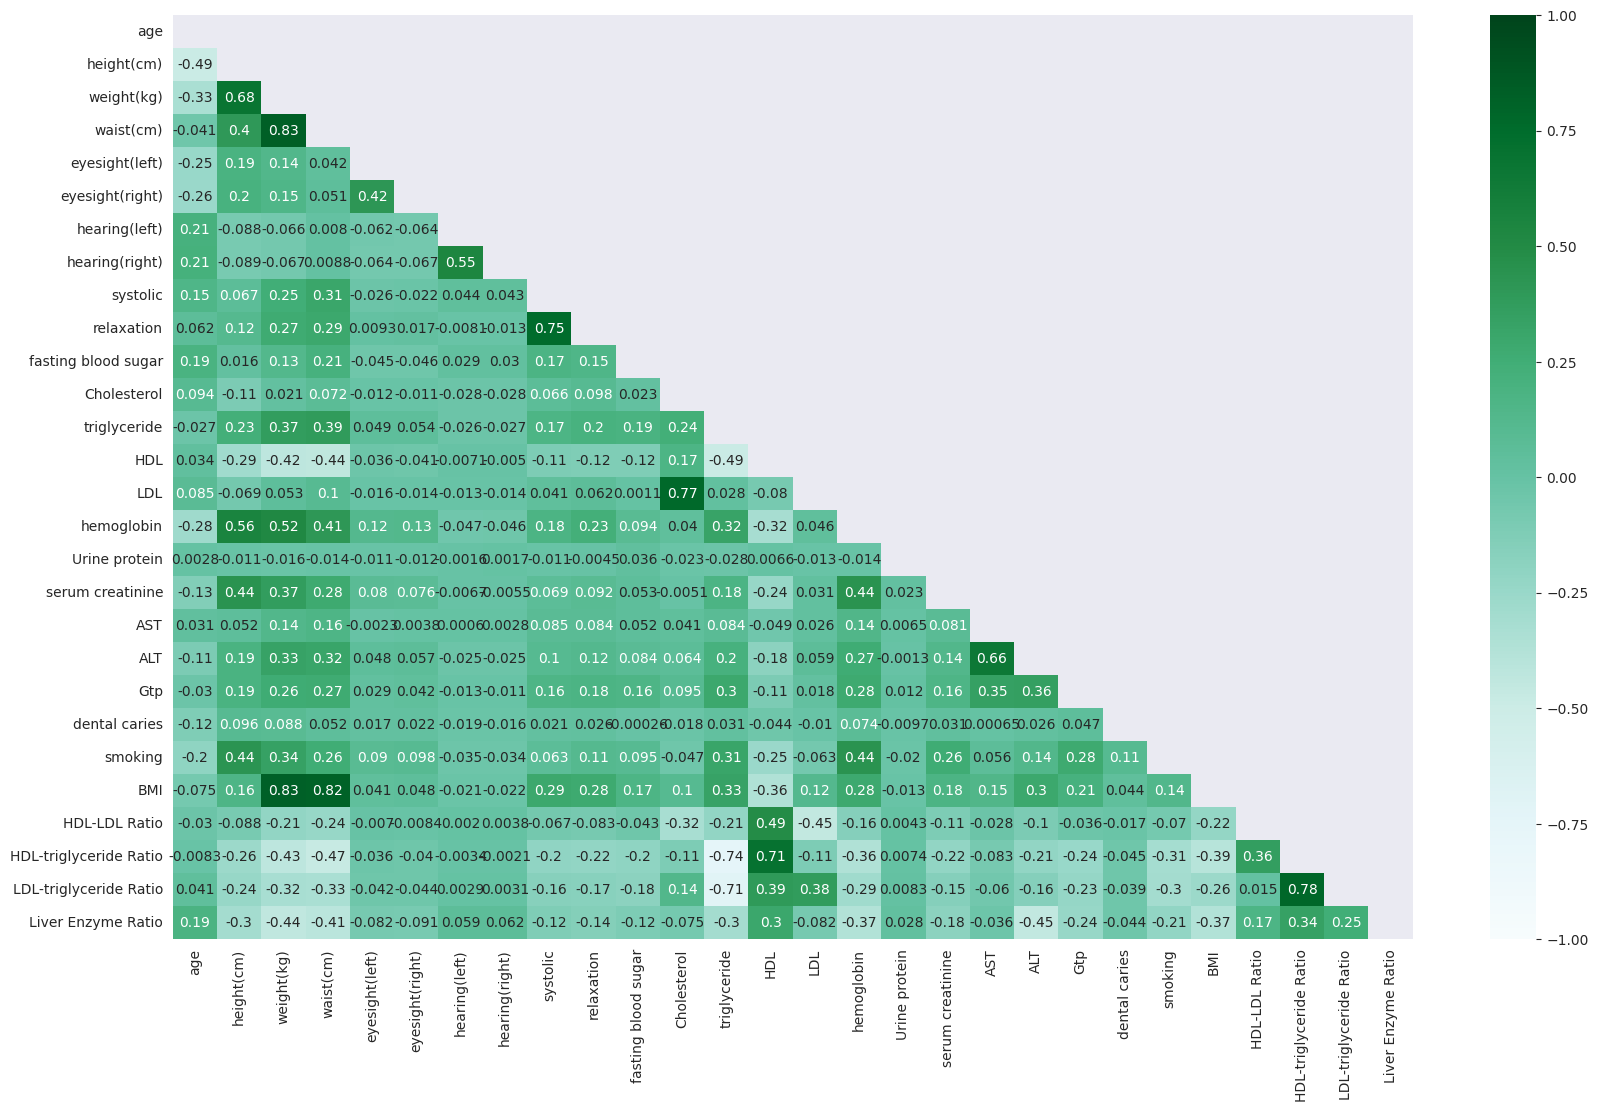

In [8]:
mask = np.triu(np.ones_like(train_data.corr()))
plt.figure(figsize=(20,12))
sns.heatmap(train_data.corr(), cmap="BuGn", annot=True, mask=mask,vmin=-1,vmax=1);

In [9]:
fig,axes = plt.subplots(23,2,figsize=(15, 60),dpi=300)

for ind,col in enumerate(orig_data.columns):
    if train_data[col].nunique()!=2:
        plt.subplot(23,2,2*ind+1)
        sns.histplot(orig_data[col],bins=15,kde=True)
        plt.gca().set_title(col)
    elif col!="smoking":
        plt.subplot(23,2,2*ind+1)
        sns.countplot(data = orig_data,x=col,hue="smoking")
        plt.gca().set_title(col)
    else:
        plt.subplot(23,2,2*ind+1)
        sns.countplot(data = orig_data,x=col)
        plt.gca().set_title(col)
    
    if train_data[col].nunique()!=2:
        plt.subplot(23,2,2*ind+2)
        sns.boxplot(orig_data[col],orient="h",palette="BuGn")
        plt.gca().set_title(col)
    else:
        plt.subplot(23,2,2*ind+2)
        sns.histplot(binwidth=0.5, x="dental caries", hue="smoking", data=orig_data, stat="count", multiple="stack",palette="BuGn")
        plt.gca().set_title(col)

fig.tight_layout()
plt.show()

<div id="4" style="background-color: #DDDDDD; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #000000; font-weight: bold; font-size: 42px;">
   Training Models
    </h1>
</div>

In [10]:
seed = np.random.seed(6)

X = train_data.drop(["smoking"],axis=1)
y = train_data["smoking"]

<div id="4.1" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.1 Baseline LGBM Model
    </h1>
</div>
<hr>

In [11]:
lgbmmodel = LGBMClassifier(random_state=seed, device="gpu")
print("CV score of LGBM is ",cross_val_score(lgbmmodel,X,y,cv=4, scoring = 'roc_auc').mean())

CV score of LGBM is  0.8607083905464648


<div id="4.2" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.2 Optuna Tuning LGBM
    </h1>
</div>
<hr>

In [12]:
# def objective(trial):
#     params = {
#         'n_estimators' : trial.suggest_int('n_estimators',500,1000),
#         "max_depth":trial.suggest_int('max_depth',3,50),
#         "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True),
#         "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
#         "min_child_samples" : trial.suggest_int('min_child_samples',1,250),
#         "subsample" : trial.suggest_float('subsample', 0.2, 1),
#         "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
#         "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
#         'num_leaves' : trial.suggest_int('num_leaves', 2, 128),
#     }
#     lgbmmodel_optuna = LGBMClassifier(**params,random_state=seed,device="gpu")
#     cv = cross_val_score(lgbmmodel_optuna, X, y, cv = 4,scoring='roc_auc').mean()
#     return cv

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100,timeout=2000)

In [13]:
# 0.8686512553111709
lgbm_params = {'n_estimators': 624, 'max_depth': 46, 'learning_rate': 0.06953273561619135,
               'min_child_weight': 2.4187716216112944, 'min_child_samples': 230, 'subsample': 0.9515130309407626,
               'subsample_freq': 4, 'colsample_bytree': 0.402284262124352, 'num_leaves': 71}

lgbm_opt = LGBMClassifier(**lgbm_params,random_state=seed,device="gpu")
lgbm_opt.fit(X,y)
print("CV score of LGBM Optuna is ",cross_val_score(lgbm_opt,X,y,cv=4, scoring = 'roc_auc').mean())

CV score of LGBM Optuna is  0.8686679718080159


<div id="4.3" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.3 StratifiedKFold LGBM Model
    </h1>
</div>
<hr>

In [14]:
submission = pd.DataFrame()
submission["id"] = test_data.index
submission["lgbm_smoking"] = 0
submission["cat_smoking"] = 0

In [15]:
SPLITS = 5
lgbm_auc_score = []

for i,(tr,val) in enumerate(StratifiedKFold(n_splits=SPLITS,random_state=seed).split(X,y)):
    
    print("-"*25,"FOLD",i,"-"*25)
    X_train, X_test, y_train, y_test = X.iloc[tr,:],X.iloc[val,:],y.iloc[tr],y.iloc[val]
    
    lgbmmodel = LGBMClassifier(**lgbm_params,random_state=seed,device="gpu")
    lgbmmodel.fit(X_train,y_train, eval_set=[(X_test,y_test)], eval_names=["valid"],eval_metric=['auc'], early_stopping_rounds=10,verbose = 25)
    
    auc = roc_auc_score(y_test, lgbmmodel.predict_proba(X_test)[:,1])
    
    lgbm_auc_score.append(auc)
    print(f"Fold {i} ROC_AUC =", auc,"\n")
    submission["lgbm_smoking"] += lgbmmodel.predict_proba(test_data)[:,1]/SPLITS
    
print("-"*50)
print("CV score of LGBM is ",np.array(lgbm_auc_score).mean())

------------------------- FOLD 0 -------------------------
[25]	valid's auc: 0.854127	valid's binary_logloss: 0.485667
[50]	valid's auc: 0.860311	valid's binary_logloss: 0.456803
[75]	valid's auc: 0.863838	valid's binary_logloss: 0.447097
[100]	valid's auc: 0.865795	valid's binary_logloss: 0.44317
[125]	valid's auc: 0.866952	valid's binary_logloss: 0.440881
[150]	valid's auc: 0.868147	valid's binary_logloss: 0.43907
[175]	valid's auc: 0.868736	valid's binary_logloss: 0.438115
[200]	valid's auc: 0.869423	valid's binary_logloss: 0.437214
[225]	valid's auc: 0.869719	valid's binary_logloss: 0.436684
[250]	valid's auc: 0.870208	valid's binary_logloss: 0.435956
[275]	valid's auc: 0.870628	valid's binary_logloss: 0.435344
[300]	valid's auc: 0.870784	valid's binary_logloss: 0.435036
[325]	valid's auc: 0.870956	valid's binary_logloss: 0.434736
[350]	valid's auc: 0.871028	valid's binary_logloss: 0.434597
Fold 0 ROC_AUC = 0.8710407836293802 

------------------------- FOLD 1 ---------------------

<div id="4.4" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
   4.4 StratifiedKFold CatBoost Model
    </h1>
</div>
<hr>

In [16]:
SPLITS = 5
cat_auc_score = []

for i,(tr,val) in enumerate(StratifiedKFold(n_splits=SPLITS,random_state=seed).split(X,y)):
    
    print("-"*25,"FOLD",i,"-"*25)
    train_dataset = Pool(data=X.iloc[tr,:],label=y.iloc[tr])
    eval_dataset = Pool(data=X.iloc[val,:],label=y.iloc[val])
    
    catmodel = CatBoostClassifier(iterations=1000,verbose=100,
                                  od_type="Iter",eval_metric="AUC",
                                  random_seed=seed,early_stopping_rounds=20)
    catmodel.fit(train_dataset, use_best_model=True, eval_set=eval_dataset)
    
    auc = roc_auc_score(y.iloc[val], catmodel.predict_proba(X.iloc[val,:])[:,1])
    cat_auc_score.append(auc)
#     print(f"Fold {i} ROC_AUC =", auc,"\n")
    submission["cat_smoking"] += catmodel.predict_proba(test_data)[:,1]/SPLITS
    
print("-"*50)
print("CV score of CAT is ",np.array(cat_auc_score).mean())

------------------------- FOLD 0 -------------------------
Learning rate set to 0.110759
0:	test: 0.8238782	best: 0.8238782 (0)	total: 89.9ms	remaining: 1m 29s
100:	test: 0.8613816	best: 0.8613816 (100)	total: 3.42s	remaining: 30.4s
200:	test: 0.8644881	best: 0.8644881 (200)	total: 6.47s	remaining: 25.7s
300:	test: 0.8658193	best: 0.8658215 (296)	total: 9.36s	remaining: 21.7s
400:	test: 0.8666755	best: 0.8666918 (399)	total: 12.3s	remaining: 18.4s
500:	test: 0.8672565	best: 0.8672565 (500)	total: 15.2s	remaining: 15.2s
600:	test: 0.8677520	best: 0.8677520 (600)	total: 18.2s	remaining: 12.1s
700:	test: 0.8683816	best: 0.8683838 (695)	total: 21.1s	remaining: 9.01s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.868571432
bestIteration = 761

Shrink model to first 762 iterations.
------------------------- FOLD 1 -------------------------
Learning rate set to 0.110759
0:	test: 0.8202034	best: 0.8202034 (0)	total: 32ms	remaining: 32s
100:	test: 0.8603969	best: 0.8603969 

<div id="6" style="background-color: #DDDDDD; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #000000; font-weight: bold; font-size: 42px;">
   Plotting Feature Importance
    </h1>
</div>

In [17]:
def plotImportance(modelNames,models):
    plt.subplots(len(modelNames),1,figsize=(14,5*len(modelNames)),dpi=300)
    for ind,modelName in enumerate(modelNames):
        history = pd.DataFrame()
        history["cols"] = X_test.columns
        if modelNames[ind] == "CatBoost":
            history["imp"] = models[ind].get_feature_importance()
        else:  
            history["imp"] = models[ind].feature_importances_
        history.sort_values("imp",inplace=True,ascending=False)
        history.reset_index(drop=True)
        plt.subplot(len(modelNames),1,ind+1)
        sns.barplot(x=history["imp"],y=history["cols"],palette="rocket");
        plt.title("Feature Imporance of "+modelName)


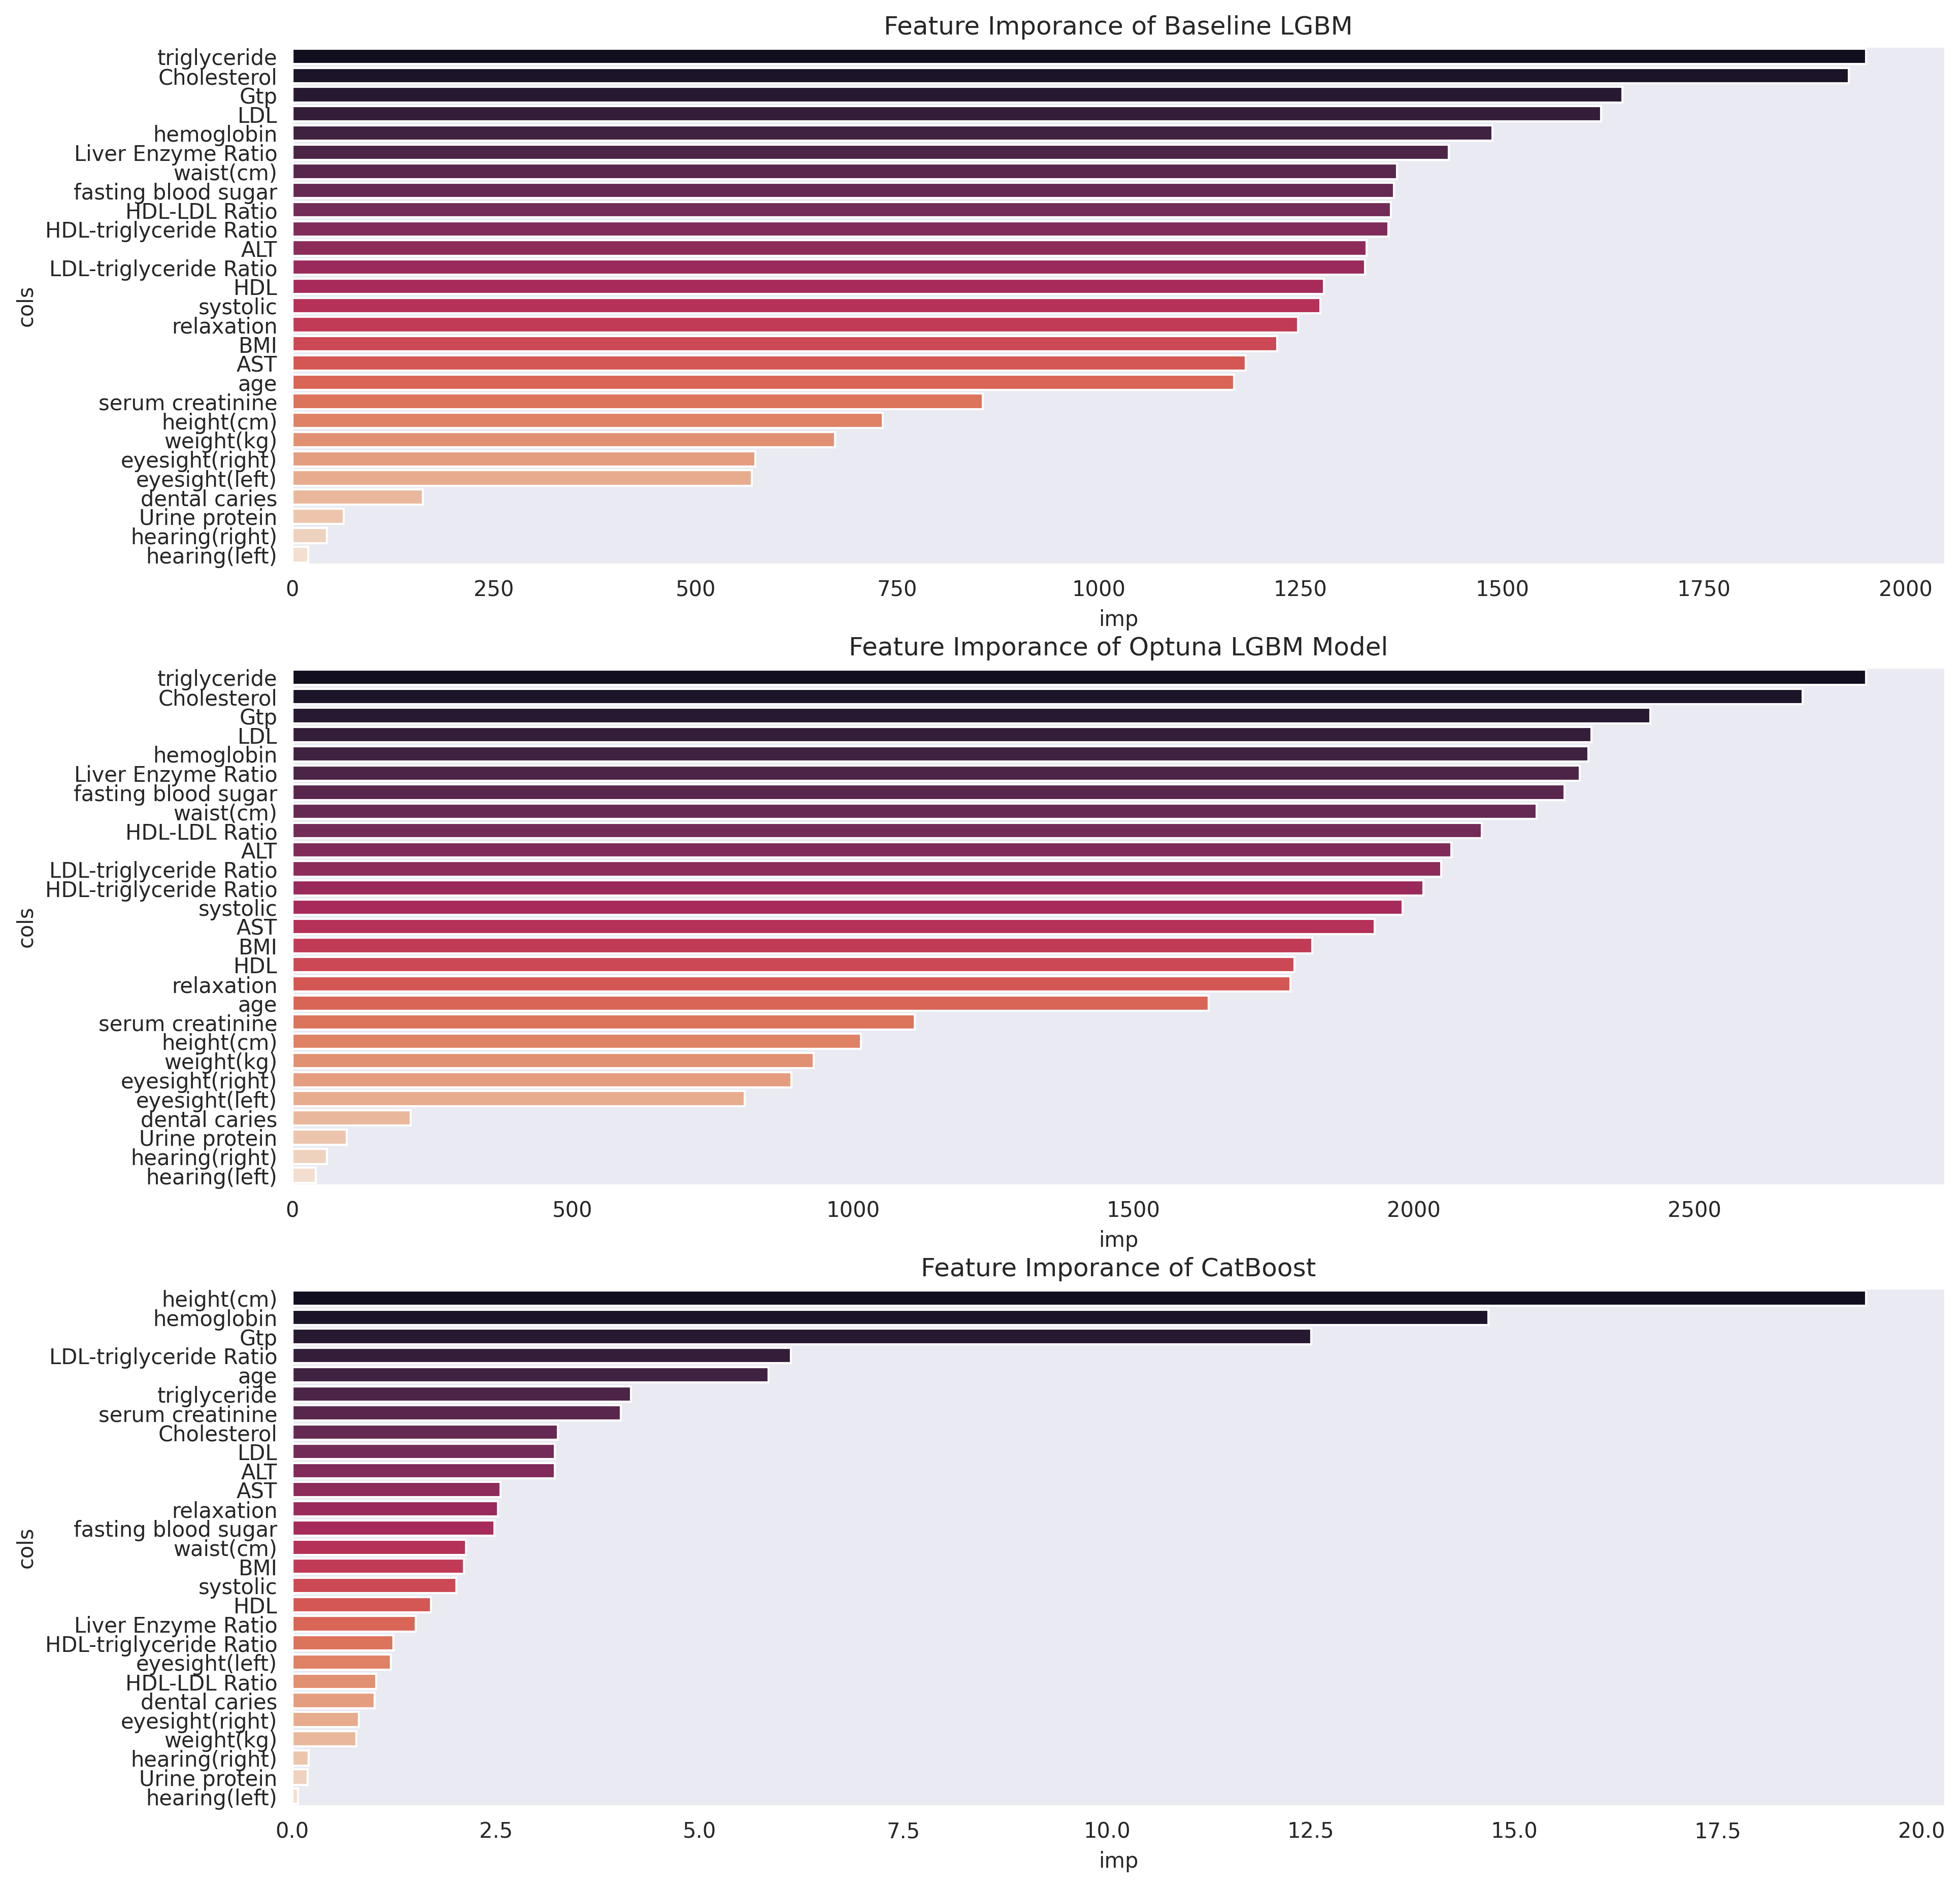

In [18]:
plotImportance(["Baseline LGBM","Optuna LGBM Model","CatBoost"],[lgbmmodel,lgbm_opt,catmodel])

<div id="7" style="background-color: #DDDDDD; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #000000; font-weight: bold; font-size: 42px;">
   Creating 'submission.csv'
    </h1>
</div>

In [19]:
submission["smoking"] = (submission["cat_smoking"]+submission["lgbm_smoking"])/2
submission.head(10)

,id,lgbm_smoking,cat_smoking,smoking
0,159256,0.646898,0.571450,0.609174
1,159257,0.317150,0.289004,0.303077
2,159258,0.353447,0.295758,0.324602
3,159259,0.017251,0.024812,0.021032
4,159260,0.572141,0.542433,0.557287
5,159261,0.939139,0.907771,0.923455
6,159262,0.520781,0.529091,0.524936
7,159263,0.046656,0.044288,0.045472
8,159264,0.167162,0.107072,0.137117
9,159265,0.020354,0.030468,0.025411


In [20]:
submission[["id","smoking"]].to_csv("submission.csv",header=True,index=False)

<div id = "8" style="background-color: #DDDDDD; padding: 20px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 42px;">
    Conclusion
    <h3 style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: center; color: #505050; line-height: 1.6;">
    If you found the notebook helpful, please Upvote the Notebook😊<br>
    If you have any suggestion, feel free to Comment & Tag me<br>
        <br>
    You can explore my another approach to this problem:<br> <a href="https://www.kaggle.com/code/iqmansingh/smoker-status-xgb-lgbm-dart-optuna-fe" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: center; color: #505050; line-height: 1.6;text-decoration: underline;;">🚬 Smoker Status | XGB+LGBM+DART | Optuna 🚀 | FE</a>
    </h3>
</div>

